In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [57]:
# Load the Dataset
file_path = "C:\VITB\Academics\Projects\Epics Project\Datasets\Medicine_description.csv"
df = pd.read_csv(file_path)

In [58]:
# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Drug_Name    22481 non-null  object
 1   Reason       22481 non-null  object
 2   Description  22467 non-null  object
dtypes: object(3)
memory usage: 527.0+ KB


(None,
                                            Drug_Name Reason  \
 0               A CN Gel(Topical) 20gmA CN Soap 75gm   Acne   
 1  A Ret 0.05% Gel 20gmA Ret 0.1% Gel 20gmA Ret 0...   Acne   
 2                             ACGEL CL NANO Gel 15gm   Acne   
 3                                ACGEL NANO Gel 15gm   Acne   
 4                              Acleen 1% Lotion 25ml   Acne   
 
                                          Description  
 0                      Mild to moderate acne (spots)  
 1  A RET 0.025% is a prescription medicine that i...  
 2  It is used to treat acne vulgaris in people 12...  
 3  It is used to treat acne vulgaris in people 12...  
 4  treat the most severe form of acne (nodular ac...  )

In [59]:
# Drop rows with missing descriptions
df = df.dropna(subset=["Description"])

In [60]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=15000)
X_tfidf = tfidf_vectorizer.fit_transform(df["Description"])

In [61]:
# Normalize TF-IDF features
X_tfidf = normalize(X_tfidf, norm='l2', axis=1)

In [62]:
# Apply NMF with optimized parameters
num_topics_list = [50, 75, 100]  # Different topic numbers to evaluate
reconstruction_errors = []

Reconstruction Error (Frobenius Norm) for 50 topics: 81.6897


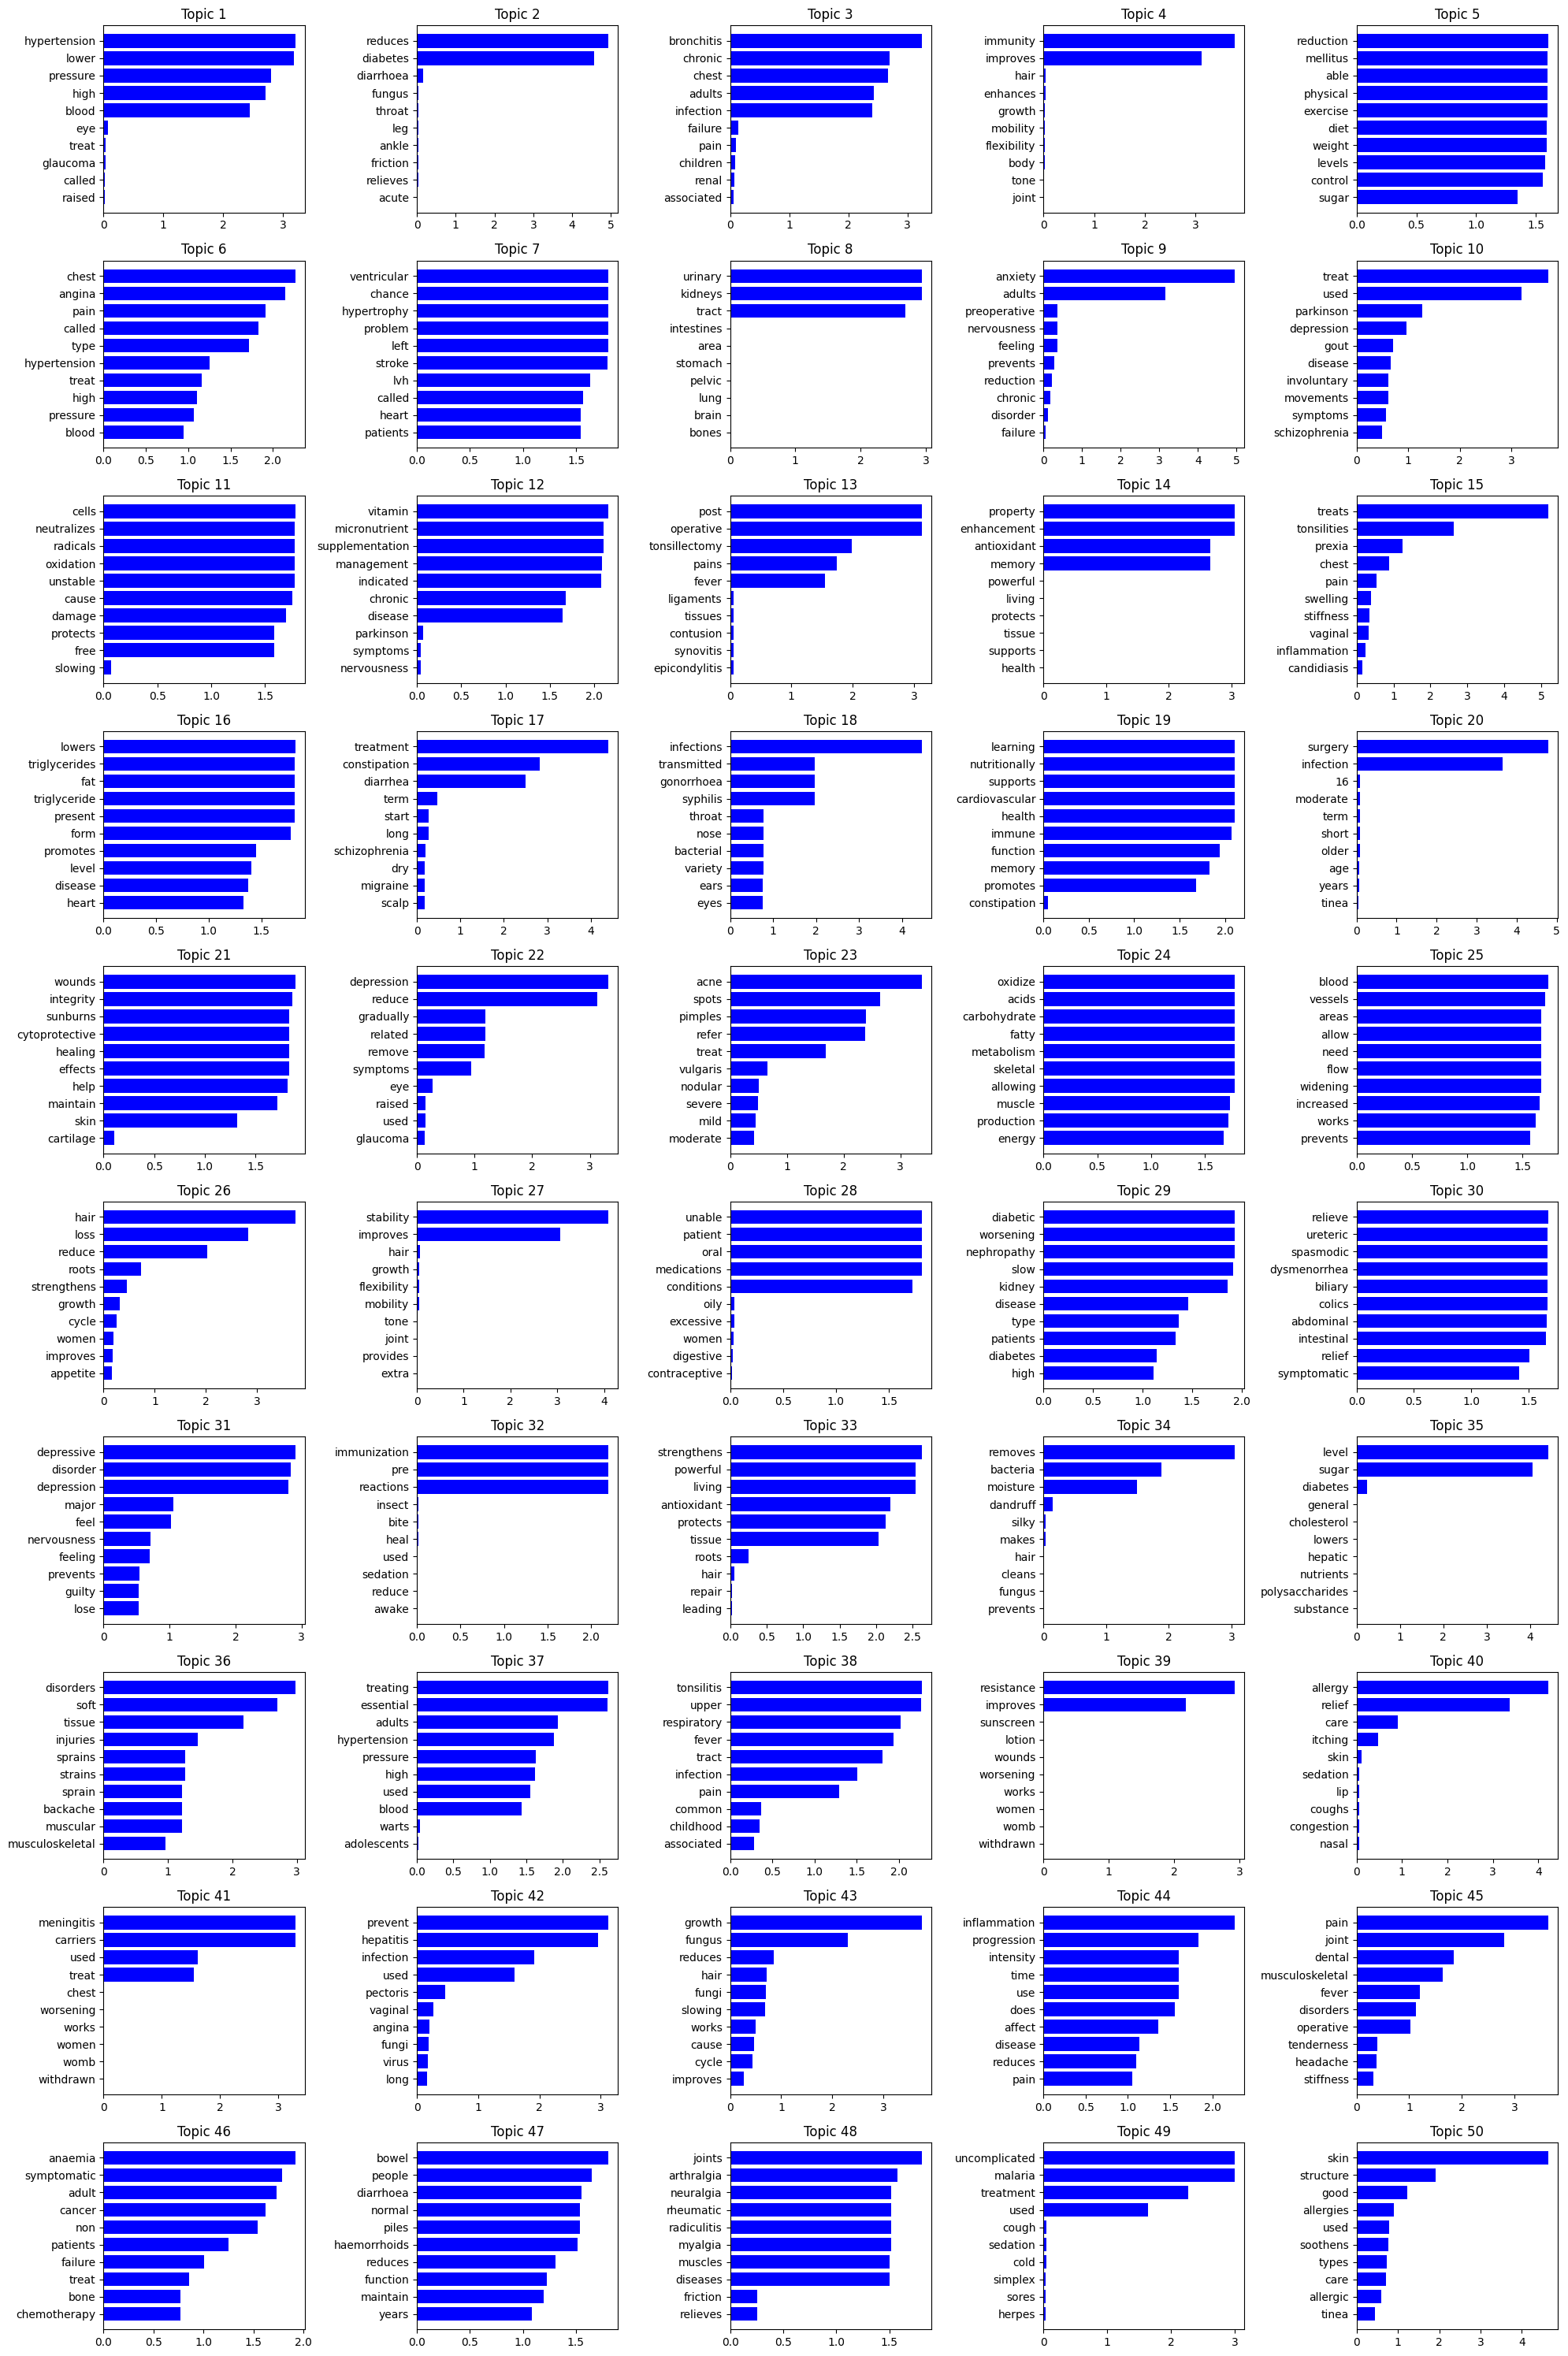

Reconstruction Error (Frobenius Norm) for 75 topics: 65.7422


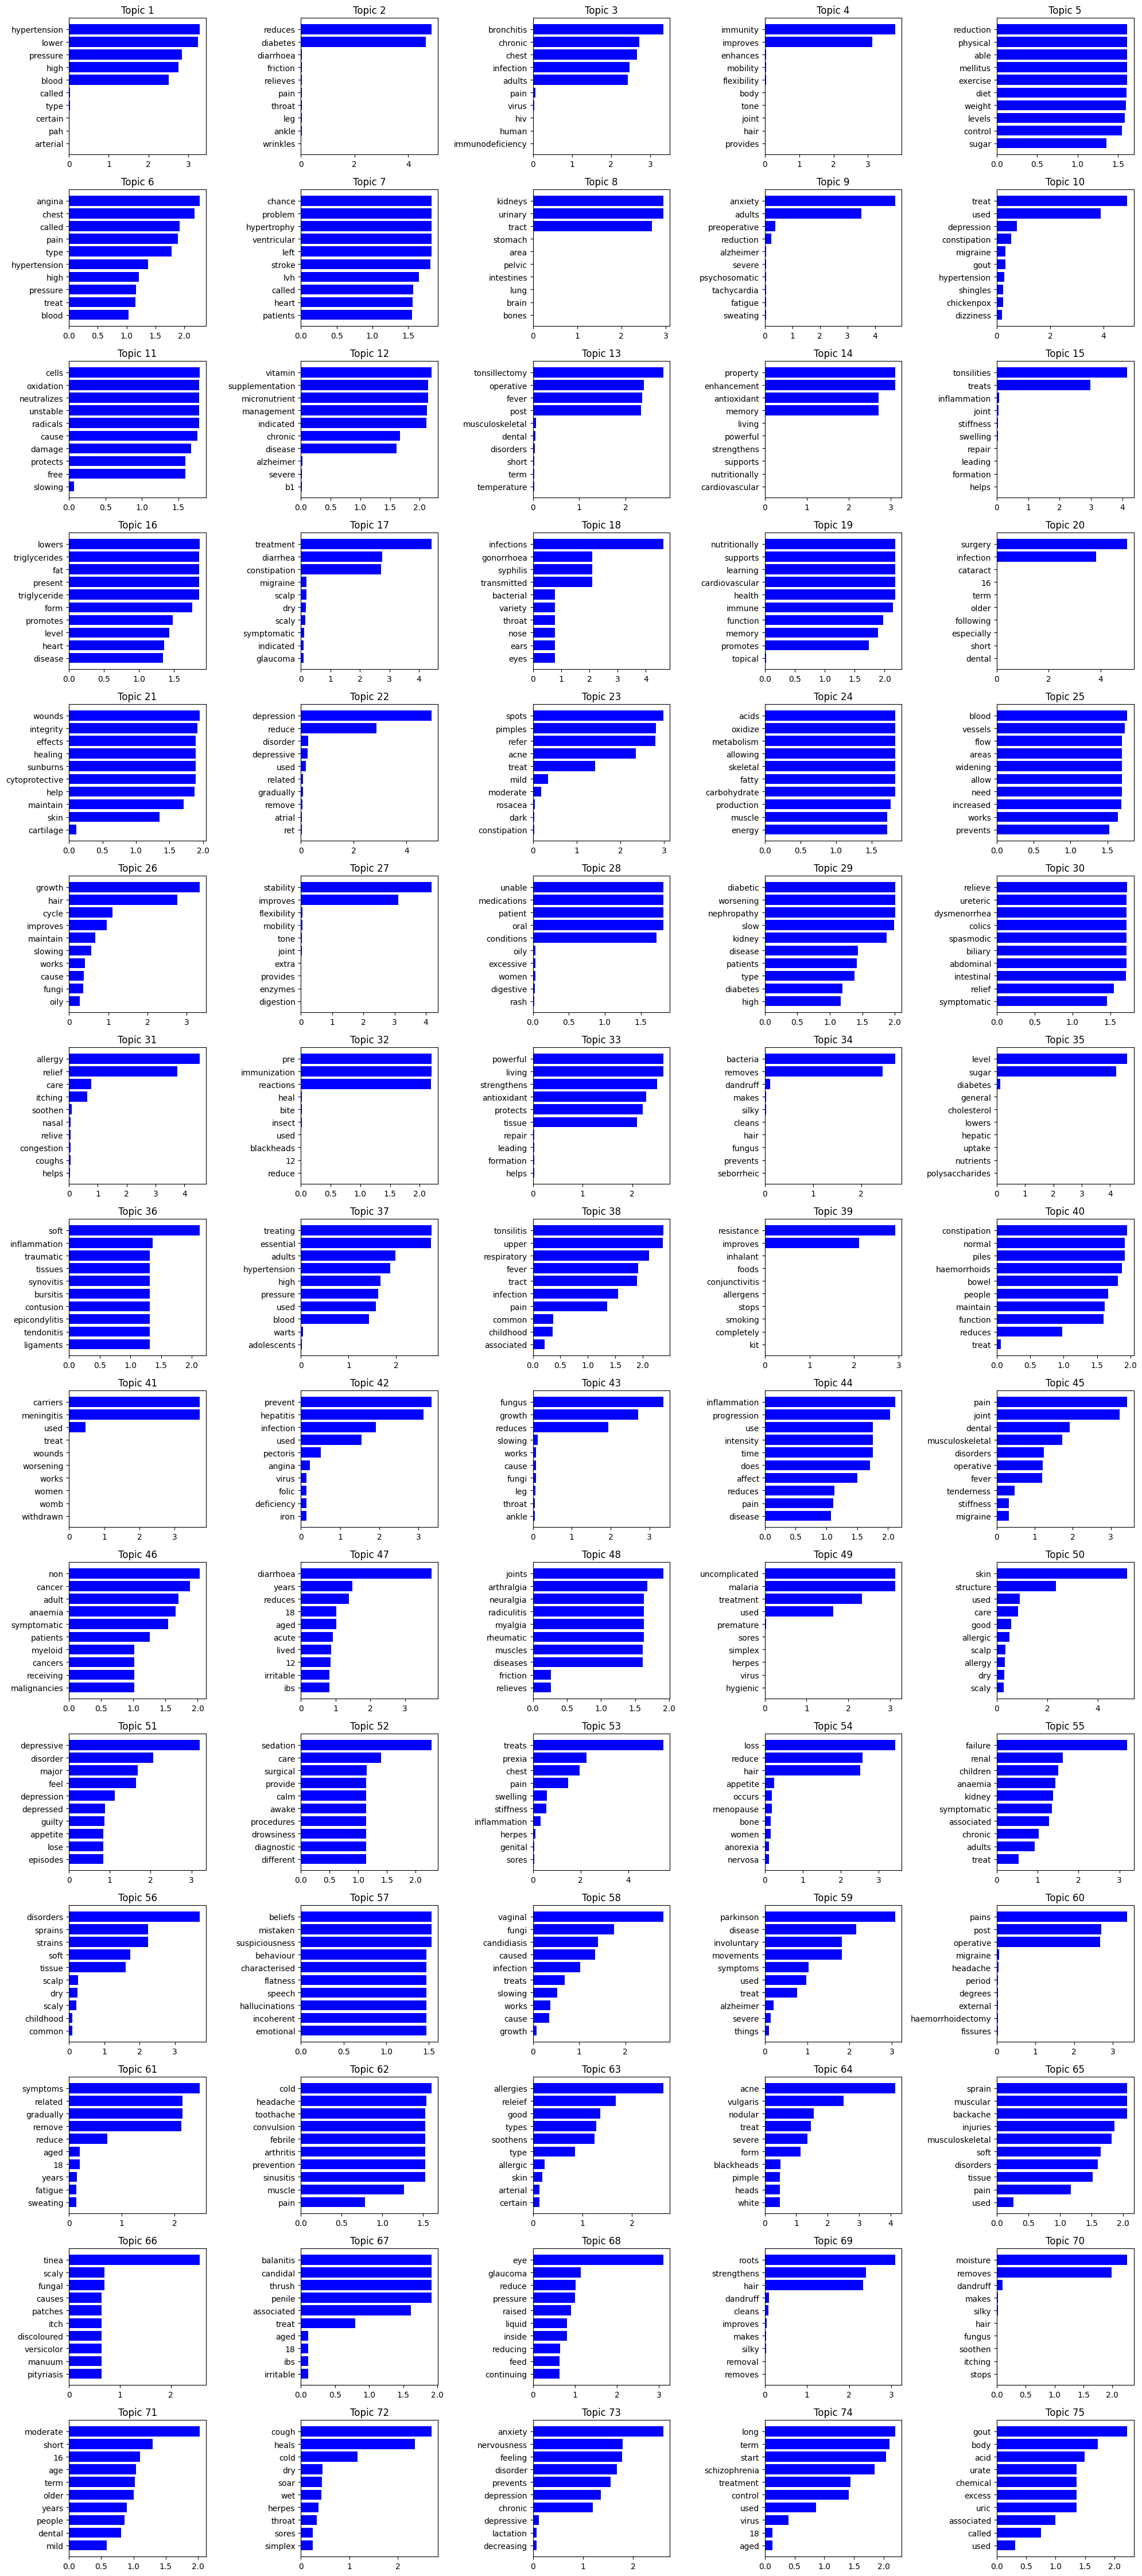

Reconstruction Error (Frobenius Norm) for 100 topics: 53.4449


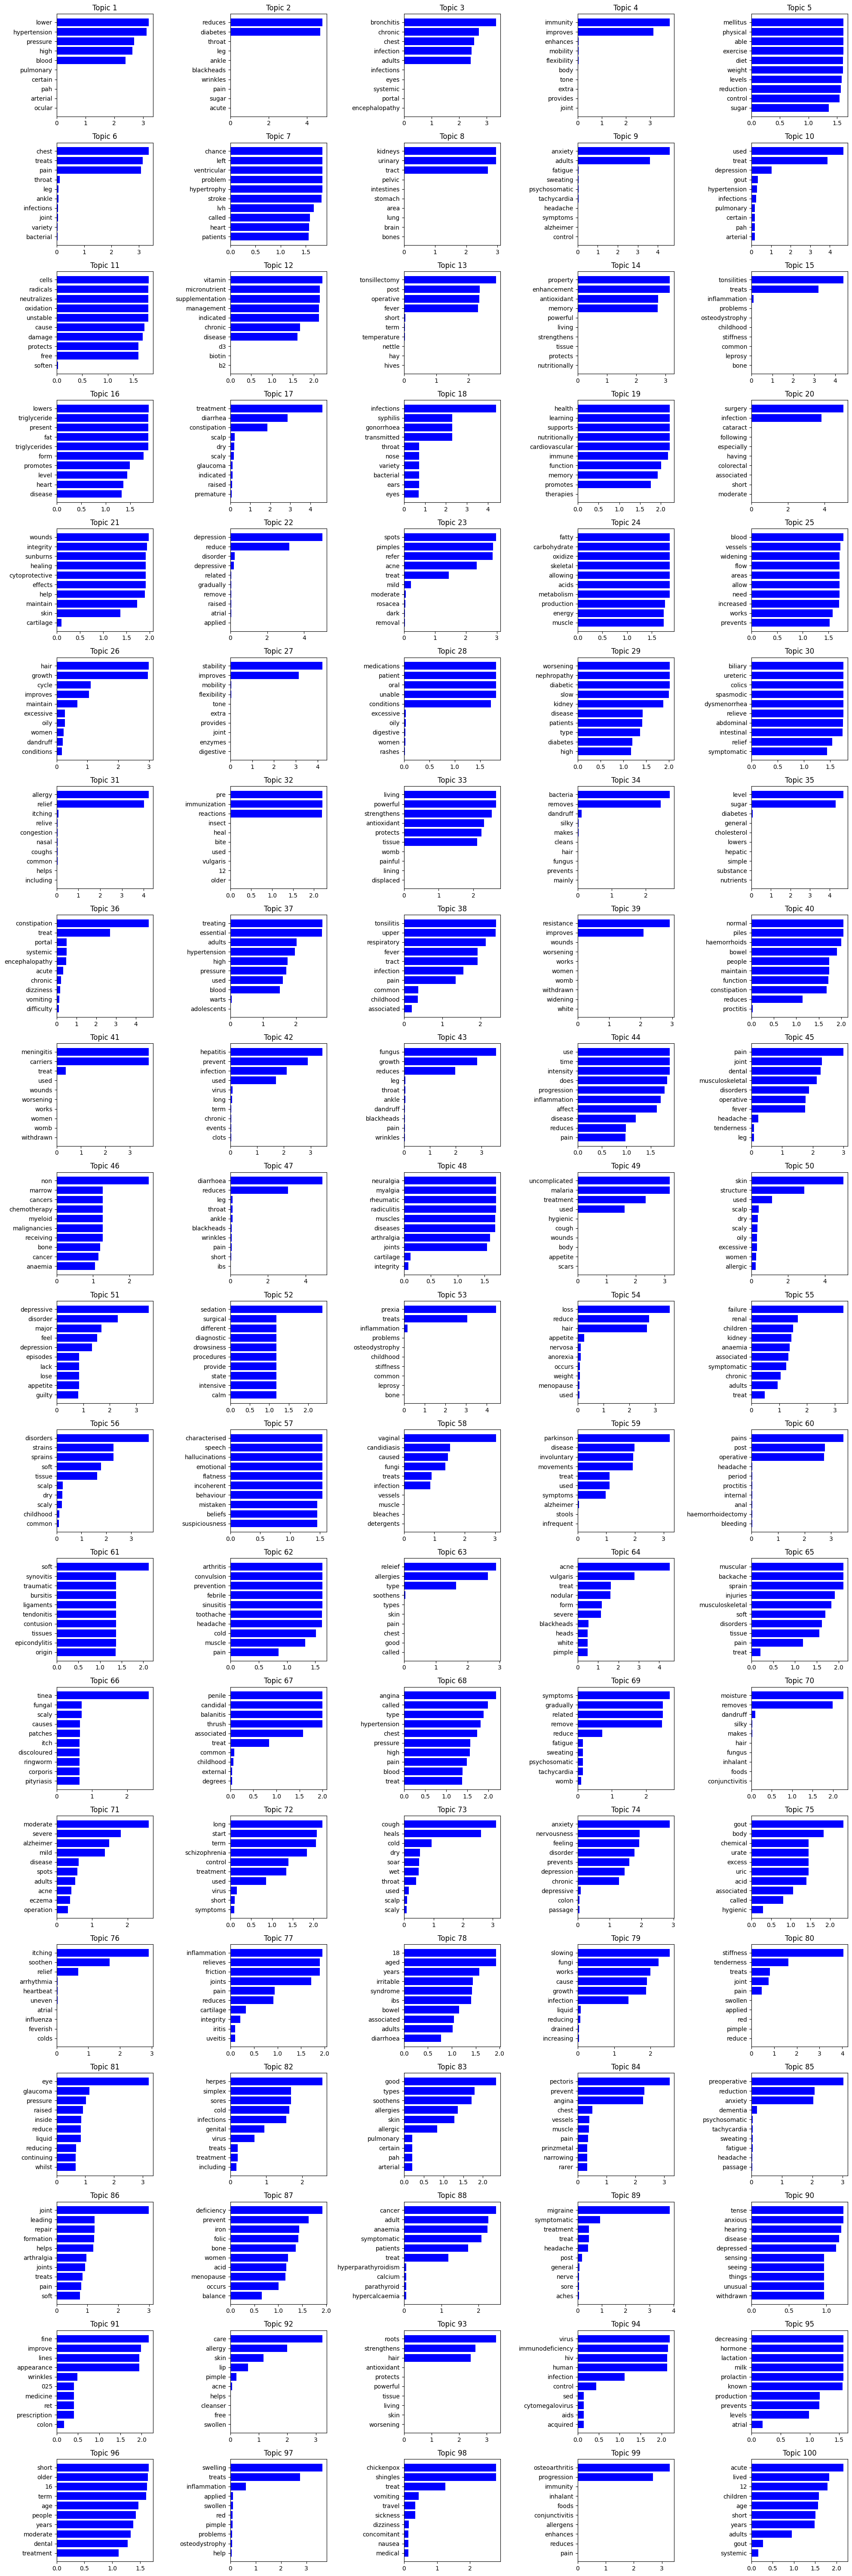

In [63]:
for num_topics in num_topics_list:
    nmf = NMF(n_components=num_topics, solver='mu', init='nndsvdar', max_iter=1500, random_state=42)
    W = nmf.fit_transform(X_tfidf)
    H = nmf.components_
    
    # Calculate Reconstruction Error
    reconstruction_error = nmf.reconstruction_err_
    reconstruction_errors.append(reconstruction_error)
    print(f"Reconstruction Error (Frobenius Norm) for {num_topics} topics: {reconstruction_error:.4f}")

    # Visualizing the top words in each topic
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    top_words = 10

    def plot_top_words(H, feature_names, top_words, num_topics):
        cols = 5
        rows = (num_topics // cols) + (num_topics % cols > 0)
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3))
        axes = axes.flatten()
        
        for topic_idx, topic in enumerate(H):
            top_features_idx = topic.argsort()[:-top_words - 1:-1]
            top_features = feature_names[top_features_idx]
            weights = topic[top_features_idx]
            
            ax = axes[topic_idx]
            ax.barh(top_features, weights, color='blue')
            ax.set_title(f'Topic {topic_idx + 1}')
            ax.invert_yaxis()
        
        for i in range(topic_idx + 1, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
    
    plot_top_words(H, feature_names, top_words, num_topics)


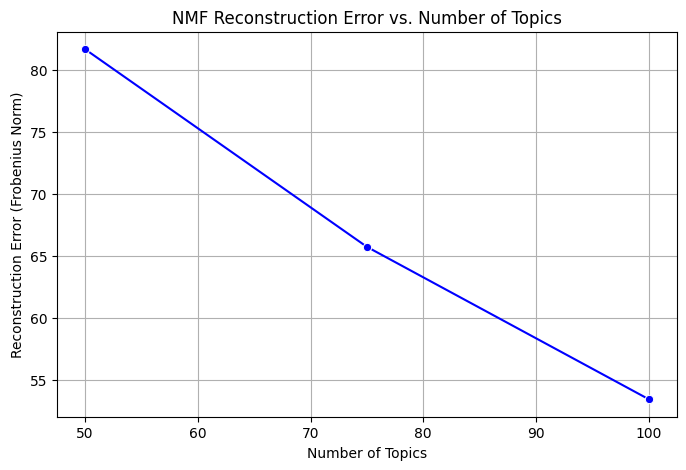

In [72]:
# Plot Reconstruction Errors
plt.figure(figsize=(8,5))
sns.lineplot(x=num_topics_list, y=reconstruction_errors, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error (Frobenius Norm)")
plt.title("NMF Reconstruction Error vs. Number of Topics")
plt.grid(True)
plt.show()

In [65]:
# Encode target labels
y = df["Reason"].astype('category').cat.codes

In [66]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(W, y, test_size=0.2, random_state=42)

In [73]:
# Train a classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [68]:
# Make predictions
y_pred = clf.predict(X_test)

In [69]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [70]:
# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9873
Precision: 0.9881
Recall: 0.9873
F1 Score: 0.9862


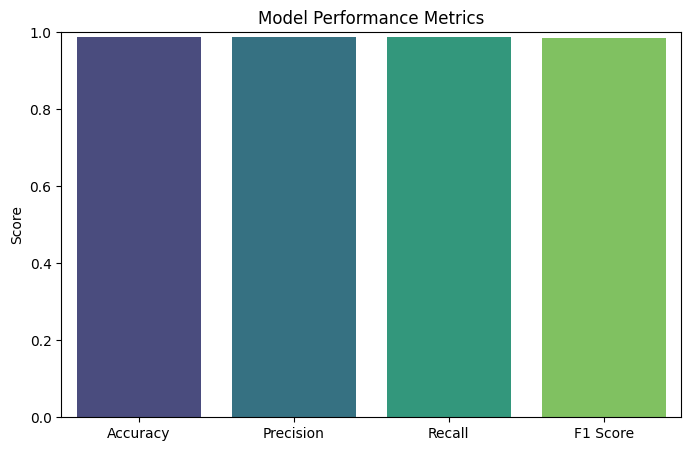

In [71]:
# Plot metrics
metrics = [accuracy, precision, recall, f1]
metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]

plt.figure(figsize=(8,5))
sns.barplot(x=metric_names, y=metrics, hue=metric_names, palette="viridis", legend=False)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.show()